# Analysis of the Bandwidth Prior

In [1]:
import torch
import numpy as np
import faiss

import matplotlib as mpl
import matplotlib.pyplot as plt

from gpytorch.priors import GammaPrior

In [2]:
torch.manual_seed(1337)
dataset = 'mnist'

data = np.loadtxt('datasets/'+dataset+'_train.csv')
sampled_x, sampled_y = data[:, 2:], data[:, 1]
rand_idx = torch.randperm(sampled_x.shape[0])
sampled_x, sampled_y = sampled_x[rand_idx], sampled_y[rand_idx]

split = int(0.2 * sampled_x.shape[0])
train_x, train_y = sampled_x[:split], sampled_y[:split]

In [3]:
res = faiss.StandardGpuResources()
knn = faiss.GpuIndexIVFFlat(res, sampled_x.shape[1], 1, faiss.METRIC_L2)
knn.train(sampled_x)
knn.add(sampled_x)
v = np.sqrt(knn.search(sampled_x, 51)[0][:,1:])
v_sorted = np.sort(v.mean(axis=1).ravel())

min_val = 1e-3
eps_min = np.sqrt(v[:, 0].max()**2/(-4*np.log(min_val)))

p_5 = int(np.round(v_sorted.shape[0]*0.05))
p_50 = int(np.round(v_sorted.shape[0]*0.5))
beta = 4*v_sorted[p_50]/(v_sorted[p_50]-eps_min)**2
alpha = beta * v_sorted[p_50] + 1
dist = torch.distributions.gamma.Gamma(alpha, beta)
HIST_BINS = np.linspace(0, v.max(), 100)

print("p_5: ", v_sorted[p_5])
print("p_50: ", v_sorted[p_50])
print("v_max: ", v.max())
print("eps_min: ", eps_min)

p_5:  0.5048939
p_50:  0.7397403
v_max:  3.5810528
eps_min:  0.05988996382496131


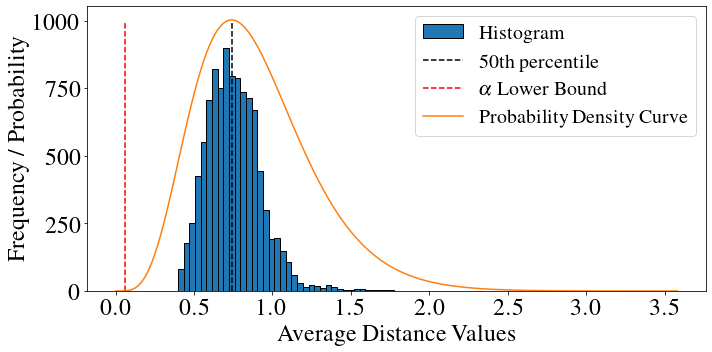

In [4]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# Plot histogram
ax.hist(v_sorted, bins=HIST_BINS, edgecolor='black', label='Histogram')

# Plot vertical lines
# ax.vlines(v_sorted[p_5], 0, v_sorted.shape[0] * 0.1, colors='k', linestyles='dashed', label='5th percentile')
ax.vlines(v_sorted[p_50], 0, v_sorted.shape[0] * 0.1, colors='k', linestyles='dashed', label='50th percentile')
ax.vlines(eps_min, 0, v_sorted.shape[0] * 0.1, colors='r', linestyles='dashed', label=r'$\alpha$ Lower Bound')

# Plot probability density curve
x = torch.arange(0, v.max(), 0.01)
y = 8.7e2 * dist.log_prob(x).exp()
ax.plot(x, y, label='Probability Density Curve')

# Set labels and title
ax.set_xlabel(r'Average Distance Values', fontsize=24)
ax.set_ylabel(r'Frequency / Probability', fontsize=24)
# ax.set_title(r'Histogram and Probability Density Curve')

# Add legend
ax.legend(fontsize=20)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Adjust layout
fig.tight_layout()

# Save the plot
plt.savefig('prior_sampled.png', format='png')

In [5]:
import faiss
res = faiss.StandardGpuResources()
knn = faiss.GpuIndexIVFFlat(res, train_x.shape[1], 1, faiss.METRIC_L2)
knn.train(train_x)
knn.add(train_x)
v = np.sqrt(knn.search(train_x, 51)[0][:,1:])
v_sorted = np.sort(v.mean(axis=1).ravel())

min_val = 1e-3
eps_min = np.sqrt(v[:, 0].max()**2/(-4*np.log(min_val)))

p_5 = int(np.round(v_sorted.shape[0]*0.05))
p_50 = int(np.round(v_sorted.shape[0]*0.5))
beta = 4*v_sorted[p_50]/(v_sorted[p_50]-eps_min)**2
alpha = beta * v_sorted[p_50] + 1
dist = torch.distributions.gamma.Gamma(alpha, beta)
HIST_BINS = np.linspace(0, v.max(), 100)

print("p_5: ", v_sorted[p_5])
print("p_50: ", v_sorted[p_50])
print("v_max: ", v.max())
print("eps_min: ", eps_min)

p_5:  2.3085372
p_50:  3.4049559
v_max:  8.7707815
eps_min:  0.3276640566878602


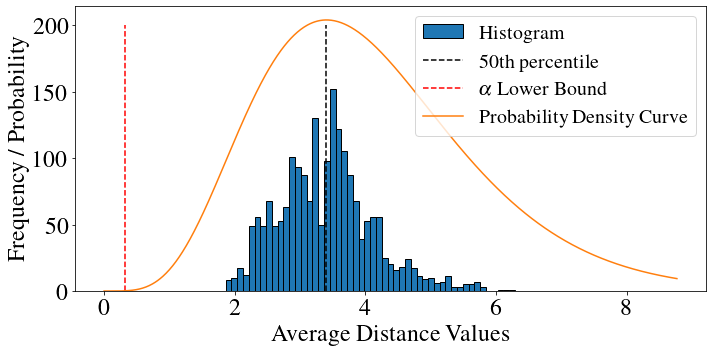

In [6]:
# Enable LaTeX rendering
mpl.rcParams['text.usetex'] = True

# Set Times as the font family
mpl.rcParams['font.family'] = 'Times'

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# Plot histogram
ax.hist(v_sorted, bins=HIST_BINS, edgecolor='black', label='Histogram')

# Plot vertical lines
# ax.vlines(v_sorted[p_5], 0, v_sorted.shape[0] * 0.1, colors='k', linestyles='dashed', label='5th percentile')
ax.vlines(v_sorted[p_50], 0, v_sorted.shape[0] * 0.1, colors='k', linestyles='dashed', label='50th percentile')
ax.vlines(eps_min, 0, v_sorted.shape[0] * 0.1, colors='r', linestyles='dashed', label=r'$\alpha$ Lower Bound')

# Plot probability density curve
x = torch.arange(0, v.max(), 0.01)
y = 8e2 * dist.log_prob(x).exp()
ax.plot(x, y, label='Probability Density Curve')

# Set labels and title
ax.set_xlabel(r'Average Distance Values', fontsize=24)
ax.set_ylabel(r'Frequency / Probability', fontsize=24)
# ax.set_title(r'Histogram and Probability Density Curve')

# Add legend
ax.legend(fontsize=20)

# Increase tick label sizes
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

# Adjust layout
fig.tight_layout()

# Save the plot
plt.savefig('prior_train.png', format='png')